
Copyright (c) 2022-present, Kakao Brain Corp.  

Licensed under the Apache License, Version 2.0 (the "License");

## Examples of Text-to-Image Generation using RQ-VAE and RQ-Transformer

This notebook includes the example codes for generating various images conditioned on texts.  
After loading the checkpoints of RQ-VAE and RQ-Transformer respectively,  
you can input various texts to generate the corresponded images.  

You can certainly adjust the sampling parameters such as `temperature`, `top_k`, and `top_p` for better quality of generated images according to the given texts.  
As the three parameters have lower values than the default setting, you can get more simple and confident images, and vice versa.

## Step 1: Import necessary libraries and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import yaml
import torch
import torchvision
import clip
import torch.nn.functional as F

from notebook_utils import TextEncoder, load_model, get_generated_images_by_texts

## Step 2: Load checkpoints of RQ-VAE, RQ-Transformer, and CLIP

In [2]:
# load stage 1 model: RQ-VAE
vqvae_path = '../saved_models/cc3m_cc12m_yfcc/stage1/model.pt'
model_vqvae, _ = load_model(vqvae_path)

Working with z of shape (1, 256, 8, 8) = 16384 dimensions.


In [3]:
# load stage 2 model: RQ-Transformer
model_path = '../saved_models/cc3m_cc12m_yfcc/stage2/model.pt'
model_ar, config = load_model(model_path, ema=False)

In [4]:
# move models from cpu to gpu
model_ar = model_ar.cuda().eval()
model_vqvae = model_vqvae.cuda().eval()

In [5]:
# the checkpoint of CLIP will be downloaded at the first time.
model_clip, preprocess_clip = clip.load("ViT-B/32", device='cpu')
model_clip = model_clip.cuda().eval()

In [6]:
# prepare text encoder to tokenize natual languages
text_encoder = TextEncoder(tokenizer_name=config.dataset.txt_tok_name, 
                           context_length=config.dataset.context_length)

## Step 3: Set your text condition and hyperparameters for image generation

In [7]:
text_prompts = 'a painting of "the persistence of memory"' # your own text
num_samples = 64
temperature= 1.0
top_k=1024
top_p=0.95

## Step 4: Image generation and sorting of the generated images according to CLIP scores.

In [8]:
pixels = get_generated_images_by_texts(model_ar,
                                       model_vqvae,
                                       text_encoder,
                                       model_clip,
                                       preprocess_clip,
                                       text_prompts,
                                       num_samples,
                                       temperature,
                                       top_k,
                                       top_p,
                                      )

Sampling: 100%|██████████| 256/256 [00:06<00:00, 41.22it/s]


## Step 5: Enjoy the results !

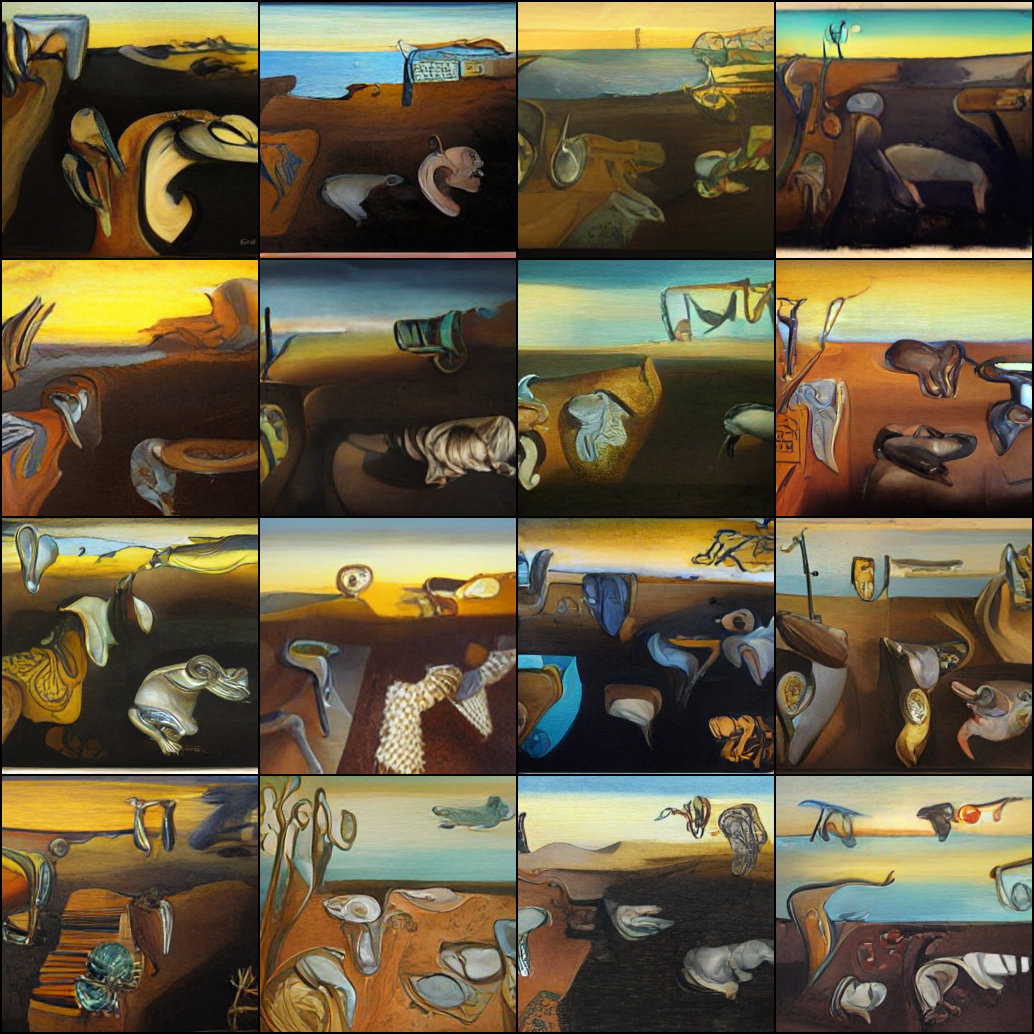

In [9]:
num_visualize_samples = 16
images = [pixel.cpu().numpy() * 0.5 + 0.5 for pixel in pixels]
images = torch.from_numpy(np.array(images[:num_visualize_samples]))
images = torch.clamp(images, 0, 1)
grid = torchvision.utils.make_grid(images, nrow=4)

img = Image.fromarray(np.uint8(grid.numpy().transpose([1,2,0])*255))
display(img)

### (Optional) Save the Images

If you want to save the generated images, use the code below.

In [10]:
img.save(f'{text_prompts}_temp_{temperature}_top_k_{top_k}_top_p_{top_p}.jpg')